In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import AmplitudeEmbedding, AngleEmbedding, RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import random



import warnings
#warnings.filterwarnings('ignore')


## Machine Learning Settings

In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
#How many Images
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "./" # Data saving folder
PREPROCESS = False           # If False, skip quantum processing and load data from SAVE_PATH
#Seeds for Randomness Generators
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Load MNIST

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

In [5]:
print("Picture size is: " + str(len(train_images[0][0])) + " x " + str(len(train_images[0])))
print()
print(train_images[1][14])

Picture size is: 28 x 28

[[0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.77647059]
 [0.99215686]
 [0.74509804]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [1.        ]
 [0.99215686]
 [0.76862745]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]


## Quantum Convolutional Kernel

In [6]:
dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

## Photo Resolution Halfer

In [7]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out


## Preprocessing

In [8]:
if PREPROCESS == True:
    
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)
    
    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")
#q_train_images = train_images
#q_test_images = test_images
print("Load Successful")

Load Successful


## Display Processed Images

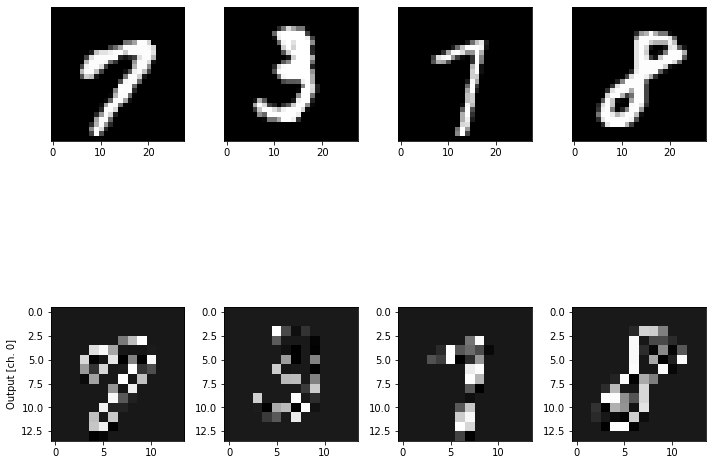

In [10]:
n_samples = 4
n_channels = 1
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    randS = random.randint(0, 50)
    axes[0, 0].set_ylabel("Input")
    if randS != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[randS, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[randS, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [11]:
print("There are " + str(len(q_train_images)) + " that are " + str(len(q_train_images[0])) + " x " + str(len(q_train_images[0][0])))





There are 50 that are 14 x 14


## Machine Learning Model

In [16]:
def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax") #0-9, 10 possible
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [17]:
#Quantum Model
q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.8593 - accuracy: 0.1800 - val_loss: 2.4480 - val_accuracy: 0.2000
Epoch 2/30
13/13 - 0s - loss: 2.0121 - accuracy: 0.2600 - val_loss: 2.2053 - val_accuracy: 0.2333
Epoch 3/30
13/13 - 0s - loss: 1.6345 - accuracy: 0.5200 - val_loss: 2.0532 - val_accuracy: 0.3000
Epoch 4/30
13/13 - 0s - loss: 1.2461 - accuracy: 0.7000 - val_loss: 1.8434 - val_accuracy: 0.3333
Epoch 5/30
13/13 - 0s - loss: 1.0477 - accuracy: 0.8000 - val_loss: 1.7302 - val_accuracy: 0.3667
Epoch 6/30
13/13 - 0s - loss: 0.8655 - accuracy: 0.9000 - val_loss: 1.6966 - val_accuracy: 0.4667
Epoch 7/30
13/13 - 0s - loss: 0.6706 - accuracy: 0.9200 - val_loss: 1.5957 - val_accuracy: 0.4333
Epoch 8/30
13/13 - 0s - loss: 0.5286 - accuracy: 0.9800 - val_loss: 1.5226 - val_accuracy: 0.4333
Epoch 9/30
13/13 - 0s - loss: 0.4559 - accuracy: 0.9600 - val_loss: 1.4454 - val_accuracy: 0.5000
Epoch 10/30
13/13 - 0s - loss: 0.3704 - accuracy: 0.9800 - val_loss: 1.4751 - val_accuracy: 0.4667
Epoch 11/30
13/13 -

In [18]:
#Classical Model
c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - loss: 2.3656 - accuracy: 0.1200 - val_loss: 2.1852 - val_accuracy: 0.0667
Epoch 2/30
13/13 - 0s - loss: 1.9940 - accuracy: 0.3400 - val_loss: 2.0517 - val_accuracy: 0.2000
Epoch 3/30
13/13 - 0s - loss: 1.6921 - accuracy: 0.6000 - val_loss: 1.9253 - val_accuracy: 0.3333
Epoch 4/30
13/13 - 0s - loss: 1.4515 - accuracy: 0.7200 - val_loss: 1.8026 - val_accuracy: 0.3667
Epoch 5/30
13/13 - 0s - loss: 1.2462 - accuracy: 0.8800 - val_loss: 1.6837 - val_accuracy: 0.4667
Epoch 6/30
13/13 - 0s - loss: 1.0785 - accuracy: 0.9200 - val_loss: 1.5945 - val_accuracy: 0.5667
Epoch 7/30
13/13 - 0s - loss: 0.9368 - accuracy: 0.9400 - val_loss: 1.5275 - val_accuracy: 0.5667
Epoch 8/30
13/13 - 0s - loss: 0.8172 - accuracy: 0.9400 - val_loss: 1.4606 - val_accuracy: 0.6000
Epoch 9/30
13/13 - 0s - loss: 0.7190 - accuracy: 1.0000 - val_loss: 1.4056 - val_accuracy: 0.6333
Epoch 10/30
13/13 - 0s - loss: 0.6361 - accuracy: 1.0000 - val_loss: 1.3664 - val_accuracy: 0.6333
Epoch 11/30
13/13 -

## Results

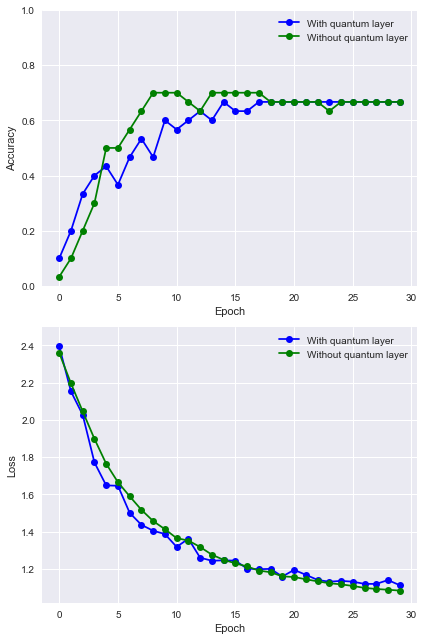

In [15]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()